# Statistiques

Aux chapitres précédents, nous avons vu comment organiser et manipuler des tableaux de données, puis les visualiser. La statistique est une collection de disciplines liées à la collecte, l'oragnisation, l'analyse, l'interprétation et la présentation de données. Les biostatistiques est l'application de ces disciplines à la biosphère.

Dans [*Principles and procedures of statistics: A biometrical approach*](https://www.amazon.com/Principles-Procedures-Statistics-Biometrical-Approach/dp/0070610282), Steel, Torie et Dickey (1997) définissent les statistiques ainsi:

> Les statistiques forment la science, pure et appliquée, de la création, du développement, et de l'application de techniques par lesquelles l'incertitude de l'induction inférentielle peut être évaluée. (ma traduction)

Alors que l'inférence consiste à généraliser des observations sur des échantillons à l'ensemble d'une population, l'induction est un type de raisonnement qui permet de généraliser des observations en théories. Les statistiques permettent d'évaluer l'incertitude découlant du processus qui permet d'abord de passer de l'échantillon à la population représenté par cet échantillon, puis de passer de cette représentation d'une population en lois générales la concernant.

Ainsi les statistiques consistent à *faire du sens* (anglicisme assumé) avec des observations: collecter des échantillons, transformer les données, effectuer des tests,  analyser les résultats, les interpréter et les visualiser. Bien que ces tâches soient complexes, en particulier en ce qui a trait aux tests statistiques, la plupart des opérations statistiques peuvent être effectuées sans l'assistance de statisticien.ne.s, à condition de comprendre suffisamment les concepts utilisés. Ce chapitre à lui seul est trop court pour permettre d'intégrer toutes les connaissances nécessaires à une utilisation raisonnée des statistiques, mais fourni les bases pour aller plus loin. Notez que les erreurs d'interprétation statistiques sont courantes et la consultation de spécialistes n'est souvent pas un luxe.

Dans ce chapitre, nous verrons comment répondre correctement à une question valide et adéquate avec l'aide d'outils de calcul scientifique. Nous couvrirons les notions de bases des distributions et des variables aléatoires qui nous permettront d'effectuer des tests statistiques commun avec Python. Nous couvrirons aussi les erreurs communément commises en recherche académique et les moyens simples de les éviter.

Ce chapitre est une introduction aux statistiques avec Python, et ne rempalcera pas un bon cours de stats.

Nous aurons besoin des modules suivants.

- Modules scientifiques de base: `numpy`, `scipy` et `pandas`
- Modules graphiques: `matplotlib` et `seaborn`
- Modules de calcul statistique: [`statsmodels`](http://www.statsmodels.org) et le sous-module `scipy.stats`.

## Poser la bonne question

La conception d'une expérience commence par une question. Ce chapitre est destinées à la statistique appliquée: il ne comprend pas la phase de conception expérimentale, une discipline a part entière. Les principes d'expérimentation sont plutôt présentés dans le cours [*Dispositifs expérimentaux (BVG-7002)*](https://www.ulaval.ca/les-etudes/cours/repertoire/detailsCours/bvg-7002-dispositifs-experimentaux.html). Également, je recommande le livre *Princpes d'expérimentation: planification des expériences et analyse de leurs résultats* de Pierre Dagnelie (2012), [disponible en ligne en format PDF](http://www.dagnelie.be/docpdf/ex2012.pdf).

- Quels sont les variables et leurs types
- Quels effets désire-t-on évaluer, de quel type de variable s'agit-il


...

## Pile ou face?

Débuttons par un exemple classique tiré d'une [conférence de Jake Vanderplas](https://www.youtube.com/watch?v=Iq9DzN6mvYA). Lorsque l'on lance une pièce de monnaie, le résultat est soit pile, soit face. Si la pièce n'est pas biaisée, la probabilité d'obtenir l'un ou l'autre de ces résultats est égale. `numpy` comprend des algorithmes pour générer des nombres aléatoires selon des distributions. Dans le cas d'un jeu de hasard à deux possibilités, on parle d'une distribution binomiale: on utilise la fonction `np.random.binomial` pour générer des tirages aléatoires. On peut lancer une pièce virtuelle avec Python. Mais avant tout, appelons `numpy`, `pandas` et `matplotlib.pyplot`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

*Mise en situation*: Vous jouez à pile ou face avec Schtroumpfette. Ce sera elle ou vous qui devrez payer un sac de chip au gagnant au jeu de pile ou face où la pèce est lancée 25 fois. Vous choisissez pile, elle choisi face. La fonction `np.random.binomial` retournera le nombre de 1 (pile). Quant à la fonction `np.random.seed`, elle assume que la sortie de la fonction aléatoire sera toujours la même à chaque fois que la cellule sera exécutée (pour les fins de l'exemple).

In [3]:
np.random.seed(seed=184008)
pf_result = np.random.binomial(n=25, p=0.5)
pf_result

19

Fantastique, vous avez 19 lancés à votre faveur: vous vous pressez de commissionner Schtroumpfette au dépanneur pour un sac de chips aux baies schtroumpfantes. Mais Schtroumpfette n'est pas d'accord: pour elle, un tel score ne peut pas avoir été le résultat d'une pièce non biaisée. Vous pourriez alors demander au Schtroumpf ingénieur d'examiner la distribution de la masse dans la pièce: mais ce serait une approche mécanistique laborieuse, et il s'avère que Schtroumpfette, qui est ferrée en stats, y va de manière analytique.

La probabilité d'obtenir l'un ou l'autre des résultats (disons face, ou $F$) est de 50%, donc $P\left( F \right) = \frac{1}{2}$. La probabilité d'obtenir deux $F$ consécutifs est de $P\left( FF \right) = \left( \frac{1}{2} \right)^2$.

La probabilité d'obtenir face, face, pile est de $P\left( FF \right) = \left( \frac{1}{2} \right)^3$. Mais l'ordre dans lequel les résultats sont obtenu n'est pas important dans la question. Alors, la probabilité d'obtenir 2 face et un pile est de $P\left( 2F, 1P \right) = P\left( FFP \right) + P\left( FPF \right) + P\left( PFF \right) = \frac{3}{8}$.

Schtroumpfette connait la fonction d'une distribution binômiale, qui permet de généraliser le calcul de probabilité lorsque l'ordre n'est pas important, avec $k$ succès d'une probabilité $p$ avec $n$ tirages.

$$P\left(n, k\right) = \binom{n}{k} p^k \left( 1-p \right)^{n-k}$$

où 

$$\binom{n}{k} = \frac{n!}{k!\left( n-k\right)!}$$

où $n! = n \times \left(n-1 \right) \times ... \times 2 \times 1$.

Schtroumpfette recherche la probabilité d'obtenir un tel résultat en supposant que la pièce n'est pas biaisée (i.e. que la probabilités d'obtenir face ou pile est de 0.5). Vous commencez à être agile en Python et vous encodez la formule que Schtroumpfette vous transmet.

In [4]:
def my_binomial(n, k, p):
    nk = np.math.factorial(n) / (np.math.factorial(k) * np.math.factorial(n-k))
    prob = nk * p**k * (1-p)**(n-k)
    return prob

Vous calculez les probabilités d'obtenir des résultats de 19 à 25 inclusivement, puis vous en faites la somme.

In [5]:
probs = []
for i in range(19, 26): # avec range, la limite supérieure est exclue
    probs.append(my_binomial(25, i, 0.5))
    
print("La probabilité d'obtenir 19 piles ou plus est de",
       np.sum(probs) * 100, "%") 

La probabilité d'obtenir 19 piles ou plus est de 0.731664896011 %


Vous pouvez aussi bien utiliser le sous-module `stats` de `scipy`.

In [91]:
from scipy import stats
stats.binom(25, 0.5).pmf(range(19, 26)).sum()

0.0073166489601135185

La probabilité que vous venez de calculer est une **p-value**.

Une **p-value** est une probabilité que le résultat soit obtenu de manière aléatoire si l'hypothèse nulle est vraie.

Dans le cas qui nous concerne, il s'agit de la probabilité d'obtenir 19 succès ou plus dans un jeu non biaisé. La convention veut que le seuil de significativité d'un test en biostatistique soit de 5%. Dans ce cas particulier, la probabilité de 0.7% est plus faible que 5% et nous pouvons conclure à ce seuil que la pièce est biaisée. 

Nous y reviendrons, mais retenez pour l'instant que la **p-value** est dans la littérature scientifique une source importante de mauvaise interprétation et que le seuil purement arbitraire de 5% n'est pas un seuil particulièrement prudent.

Puisque vous maîtrisez bien Python, vous désirez éviter les formulations statistiques. Vous modélisez alors un grand nombre de jeux de 25 lancés que vous savez non-biaisés (avec `numpy`), puis vous calculez la proportion de ces lancés qui donnent 19 piles ou plus. Comme ceci.

In [6]:
more_than_19 = 0 # initialisation du décompte des jeux où vous gagnez avec 19 et plus
n_sim = 100000 # nombre de simulations
for i in range(n_sim):
    pf_result = np.random.binomial(n=25, p=0.5) # tirage
    if pf_result >= 19: # si le tirage donne 19 ou plus, ajouter 1 au décompte
        more_than_19 = more_than_19 + 1

print("La proportion des", n_sim, 
      "simulations ayant obtenu 19 piles ou plus est de",
      more_than_19/n_sim * 100, "%")

La proportion des 100000 simulations ayant obtenu 19 piles ou plus est de 0.766 %


Le résultat est semblable. Pour une personne habituée à réfléchir en terme de code, les tenants et aboutissants du processus par modélisation sont bien plus intuitif qu'un développement analytique. La formulation analytique reste néanmoins la référence en science.

La probabilité que la pièce ne soit pas biaisée est faible. Étant donné que nous avons nous-même écrit le code pour générer le tirage, nous pouvons auditer notre pièce de monnaie virtuelle. Or nous vions bien écrit `pf_result = np.random.binomial(n=25, p=0.5)`, où `p=0.5` indique que la pièce n'était pas biaisée. Bien que la probabilité que la pièce ne soit pas biaisée est très faible, cette probabilité n'est pas nulle. Trancher l'enjeu au seuil 0.05 nous mène vers une erreur de diagnostique de type 1, où nous rejetons l'hypothèse nulle alors qu'elle est vraie.

## Les variables

Nous avons abordé au chapitre 3 la notion de *variable* par l'intermédiaire d'une donnée. Une variable est l'observation d'une caractéristique décrivant un échantillon et qui est susceptible de varier d'un échantillon à un autre. Si les observations varient en effet d'un échantillon à un autre, on parlera de variable aléatoire. Même le hasard est régit par certaines loi: ce qui est aléatoire dans une variable peut être décrit par des **lois de probabilité**, que nous verrons plus bas.

Mais restons aux variables pour l'instant. Par convention, on peut attribuer aux variables un symbole mathématique. Par exemple, on peut donner à la masse volumique d'un sol (qui est le résultat d'une méthodologie précise) le sympole $\rho$. Lorsque l'on attribue une valeur à $\rho$, on parle d'une donnée. Chaque donnée d'une observation a un indice qui lui est propre, que l'on désigne souvent par $i$, que l'on place en indice $\rho_i$. Pour la première donnée, on a $i=1$, donc $\rho_1$. Pour un nombre $n$ d'échantillons, on aura $\rho_1$, $\rho_2$, $\rho_3$, ..., $\rho_n$, formant le vecteur $\rho = \left[\rho_1, \rho_2, \rho_3, ..., \rho_n \right]$.

En Python, une variable est associée à une liste, une matrice unidimentionnelle (i.e. un vecteur) ou une colonne d'un tableau `pandas` (notez que `iPython`, l'interprétateur de commande de `Jupyter`, accepte les lettres grecques).

In [24]:
ρ = np.array([1.34, 1.52, 1.26, 1.43, 1.39]) # matrice 1D
data = pd.DataFrame({'ρ': ρ}) # tableau
data

,ρ
0,1.34
1,1.52
2,1.26
3,1.43
4,1.39


Il existe plusieurs types de variables, qui se regroupe en deux grandes catégories: les **variables quantitatives** et les **variables qualitatives**.

### Variables quantitatives

Ces variables peuvent être continuent dans un espace échantillonal réel ou discrètes dans un espace échantillonnal ne considérant que des valeurs fixes. Notons que la notion de nombre réel est toujours une approximation en sciences expérimentales comme en calcul numérique, étant donnée que l'on est limité par la précision des appareils comme par le nombre d'octets à utiliser. Bien que les valeurs fixes des disctributions discrètes ne soient pas toujours des valeurs entières, c'est bien souvent le cas en biostatistiques comme en démocgraphie, où les décomptes d'individus sont souvents présents (et où la notion de fraction d'individus n'est pas acceptée).

### Variables qualitatives

On exprime parfois qu'une variable qualitative est une variable impossible à mesurer numériquement: une couleur, l'appartenance à espèce ou à une série de sol. Pourtant, dans bien des cas, les variables qualitatives peut être encodées en variables quantitatives. Par exemple, on peut accoler des pourcentages de sable, limon et argile à un loam sableux, qui autrement est décrit par la classe texturale d'un sol. Pour une couleur, on peut lui associer des pourcentages de rouge, vert et bleu, ainsi qu'un ton. En ce qui a trait aux variables ordonnées, il est possible de supposer un étalement. Par exemple, une variable d'intensité faible-moyenne-forte peut être transformée linéairement en valeurs quantitatives -1, 0 et 1. Attention toutefois, l'étalement peut parfois être quadratique ou logarithmique. Les séries de sol peuvent être encodées par la proportion de gleyfication ([Parent et al., 2017](https://www.frontiersin.org/articles/10.3389/fenvs.2017.00081/full#B4)). Quant aux catégories difficilement transformables en quantités, on pourra passer par l'**encodage catégoriel**, souvent appelé *dummyfication*.

### Encodage catégoriel

Une variable à $C$ catégories pourra être déclinée en $C$ variables dont chaque colonne désigne par un 1 l'appartenance au groupe de la colonne et par un 0 la non-appartenance. Pour l'exemple, créons un vecteur désignant le cultivar de pomme de terre.

In [34]:
data = pd.DataFrame({'cultivar': ['Superior', 'Superior', 'Superior', 'Russet', 'Kenebec', 'Russet']}) # créer un tableau
dummies = pd.get_dummies(data) # encodage catégoriel
pd.concat([data, dummies], axis=1) # coller data et dummies l'un contre l'autre

,cultivar,cultivar_Kenebec,cultivar_Russet,cultivar_Superior
0,Superior,0,0,1
1,Superior,0,0,1
2,Superior,0,0,1
3,Russet,0,1,0
4,Kenebec,1,0,0
5,Russet,0,1,0


Nous avons trois catégories, encodées en trois colonnes. Il reste toutefois un détail important à régler: la redondance d'information. En partant du principe que l'appartenance à une catégorie est mutuellement exclusive, c'est-à-dire qu'un échantillon ne peut être assigné qu'à une seule catégorie, on peut déduire une catégorie à partir de l'information sur toutes les autres. Par exemple, si `cultivar_Russet` et `cultivar_Superior` sont toutes deux égalent à $0$, on concluera que `cultivar_Kenebec` est nécessairement égal à $1$. Et si l'un d'entre `cultivar_Russet` et `cultivar_Superior` est égal à $1$, `cultivar_Kenebec` est nécessairement égal à $0$. L'information contenue dans un nombre $C$ de catégorie peut être encodée dans un nombre $C-1$ de colonnes. C'est pourquoi, dans une analyse statistique, on désignera une catégorie comme une référence, que l'on détecte lorsque toutes les autres catégories sont encodées avec des $0$. Dans l'exemple des cultivars de pomme de terre, la transformation des variables qualitatives en variables qualitatives permettant l'analyse statistique, en prenant `cultivar_Superior` comme référence arbitraire, prendra la forme suivante.

In [41]:
dummies.drop('cultivar_Superior', axis=1)

,cultivar_Kenebec,cultivar_Russet
0,0,0
1,0,0
2,0,0
3,0,1
4,1,0
5,0,1


Pour certains modèles, vous devrez vous assurer vous-même de l'encodage. Pour d'autre, en particulier avec l'interface par formule de `statsmodels`, ce sera fait automatiquement. Nous verrons cela plus loin.

## Les probabilités

> « Nous sommes si éloignés de connaître tous les agens de la nature, et leurs divers modes d'action ; qu'il ne serait pas philosophique de nier les phénomènes, uniquement parce qu'ils sont inexplicables dans l'état actuel de nos connaissances. Seulement, nous devons les examiner avec une attention d'autant plus scrupuleuse, qu'il paraît plus difficile de les admettre ; et c'est ici que le calcul des probabilités devient indispensable, pour déterminer jusqu'à quel point il faut multiplier les observations ou les expériences, afin d'obtenir en faveur des agens qu'elles indiquent, une probabilité supérieure aux raisons que l'on peut avoir d'ailleurs, de ne pas les admettre. » — Pierre-Simon de Laplace

Une probabilité est la vraissemblance qu'un événements se réalise chez un échantillon. Les probabilités forment le cadre des systèmes stochastiques, c'est-à-dire des systèmes trop complexes pour en connaître exactement les aboutissants, auxquels ont attribue une part de hasard. Ces systèmes sont prédominants dans les processus vivants.

On peut dégager deux perspectives sur les probabilités: l'une passe par une interprétations fréquentistes, l'autre bayésiennes. L'interprétation **fréquentiste** représente la fréquence des occurences après un nombre infini d'événements. Par exemple, si vous jouez à pile ou face un grand nombre de fois, le nombre de pile sera égal à la moitié du nombre de lancés. Il s'agit de l'interprétation communément utilisée.

L'interprétation **bayésienne** vise à quantifier l'incertitude des phénomènes. Dans cette perspective, plus l'information s'accumule, plus l'incertitude diminue. Cette approche gagne en notoriété notamment parce qu'elle permet de décrire des phénomènes qui, intrinsèquement, ne peuvent être répétés infiniments (absence d'asymptote), comme celles qui sont bien définis dans le temps ou sur des populations limités.

L'approche fréquentielle teste si les données concordent avec un modèle du réel, tandis que l'approche bayésienne évalue la probabilité que le modèle soit réel. Une erreur courrante consiste à aborder des statistiques fréquentielles comme des statistiques bayésiennes. Par exemple, si l'on désire évaluer la probabilité de l'existance de vie sur Mars, on devra passer par le bayésien, car avec les stats fréquentielles, l'on devra plutôt conclure si les données sont conforme ou non avec l'hypothèse de la vie sur Mars (exemple tirée du blogue [Dynamic Ecology](https://dynamicecology.wordpress.com/2011/10/11/frequentist-vs-bayesian-statistics-resources-to-help-you-choose/)).

Des rivalités factives s'installent enter les tenants des différentes approches, dont chacune, en réalité, répond à des questions différentes dont il convient réfléchir sur les limitations. Bien que les statistiques bayésiennes soient de plus en plus utilisées, nous ne couvrirons dans ce chapitre que l'approche fréquentielle. L'approche bayésienne est néamoins traitée dans le document compplémentaire 5.1_bayes.ipynb.

## Les distributions

Une variable aléatoire peut prendre des valeurs selon des modèles de distribution des probabilités. Une distribution est une fonction mathématique décrivant la probabilité d'observer une série d'évennements. Ces événemements peuvent être des valeurs continues, des nombres entiers, des catégories, des valeurs booléennes (Vrai/Faux), etc. Dépendamment du type de valeur et des observations obtenues, on peut associer des variables à différentes lois de probabilité. Toujours, l'aire sous la courbe d'une distribution de probabilité est égale à 1.

### Binomiale

En tant que scénario à deux issues possibles, des tirages à pile ou face suivent une loi binomiale, comme toute variable booléenne prenant une valeur vraie ou fausse. En biostatistiques, les cas communs sont la présence/absence d'une espèce, d'une maladie, d'un trait phylogénétique, ainsi que les catégories encodées. Lorsque l'opération ne comprend qu'un seul échantillon (i.e. un seul tirage à pile ou face), il s'agit d'un cas particulier d'une loi binomiale que l'on nomme une loi de *Bernouilli*.

Pour 25 tirages à pile ou face indépendants (i.e. dont l'ordre des tirages ne compte pas), on peut dessiner une courbe de distribution dont la somme des probabilités est de 1.

La somme des probabilités est de 1.0


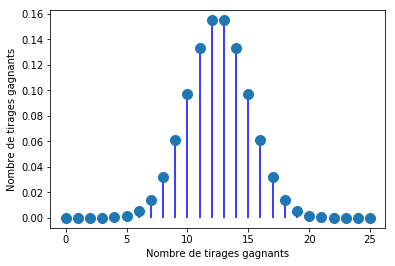

In [93]:
x = np.arange(26)
y = stats.binom(25, 0.5).pmf(x)
print('La somme des probabilités est de', y.sum())

plt.plot(x, y, 'o', markersize=10)
plt.vlines(x, 0, y, color='blue')
plt.xlabel('Nombre de tirages gagnants')
plt.ylabel('Nombre de tirages gagnants');

### Uniforme

La distribution la plus simple est probablement la distribution uniforme. Si la variable est discrète, chaque catégorie est associé à une probabilité égale. Si la variable est continue, la probabilité est directement proportionnelle à la largeur de l'intervalle.  On utilise rarement la distribution uniforme en biostatistiques, sinon pour décrire des *a prioris* vagues pour l'analyse bayésienne (ce sujet est traité dans le document 5.1_bayes.ipynb).

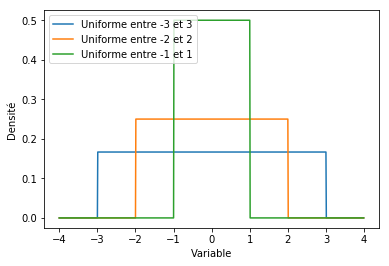

In [94]:
x = np.arange(-4, 4, 0.01) # créer un vecteur
y1 = stats.uniform.pdf(x, -3, 6) # la fonction de probabilité uniforme pour x, partant de -3, d'une largeur de 6
y2 = stats.uniform.pdf(x, -2, 4)
y3 = stats.uniform.pdf(x, -1, 2)

plt.plot(x, y1, label="Uniforme entre -3 et 3")
plt.plot(x, y2, label="Uniforme entre -2 et 2")
plt.plot(x, y3, label="Uniforme entre -1 et 1")
plt.xlabel('Variable')
plt.ylabel('Densité')
plt.legend()

### Normale / Student
La plus répendue de ces lois est probablement la loi normale, parfois nommée loi gaussienne et plus rarement loi laplacienne. Il s'agit de la distribution classique en forme de cloche. Lorsque l'on a peut d'observations, en général moins de 30, la loi normale sera avantageusement substituée par la loi de Student. Au delà de 30, la loi de Student et la loi normale sont équivalentes.

La loi normale est décrite par une moyenne, qui désigne la tendance centrale, et une variance, qui désigne l'étalement des probabilités autours de la moyenne. La racine carrée de la variance est l'écart-type.

En analyse multivariée, des données distribuées de manière multinormale ont des distributions normales sous toutes les perspectives. Elles sont désignées par un vecteur de moyennes et une matrice de covariance.

Pour les distributions mesures exclusivement positives (comme le poids ou la taille) sont parfois avantageusement approximées par une loi log-normale, ce qui est une loi normale sur le logarithme des valeurs: la moyenne d'une loi log-normale est la moyenne géométrique.

Les modules `scipy.stats` permettent de tracer des courbes normales.

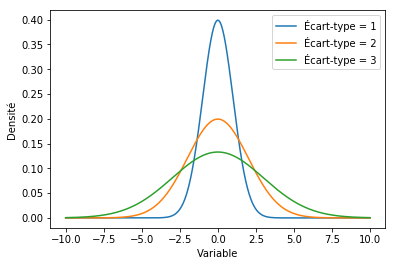

In [105]:
x = np.arange(-10, 10, 0.001) # créer un vecteur
y1 = stats.norm.pdf(x, 0, 1) # la fonction de probabilité normale pour x, moyenne de 0, écart-type de 1
y2 = stats.norm.pdf(x, 0, 2)
y3 = stats.norm.pdf(x, 0, 3)

plt.plot(x, y1, label="Écart-type = 1")
plt.plot(x, y2, label="Écart-type = 2")
plt.plot(x, y3, label="Écart-type = 3")
plt.xlabel('Variable')
plt.ylabel('Densité')
plt.legend()

Quelle est la probabilité d'obtenir le nombre 0 chez une observation continue distribuée normalement dont la moyenne est 0 et l'écart-type est de 1? Réponse: 0. La loi normale étant une distribution continue, les probabilités non-nulles ne peuvent être calculés que sur des intervalles. Par exemple, la probabilité de retrouver une valeur dans l'intervalle entre -0.1 et 0.2 est calculée en soustraiyant la probabilité cumulée à -0.1 de la probabilité cumulée à 0.2.

81.859461412 %


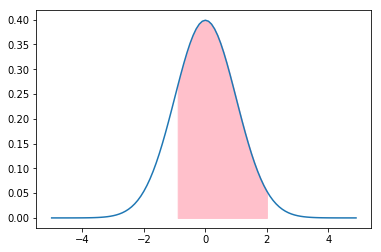

In [128]:
x = np.arange(-5, 5, 0.1) # créer un vecteur
y1 = stats.norm.pdf(x, 0, 1)

fill_condition = (x > -1) & (x<2)

plt.plot(x, y1)
plt.fill_between(x[fill_condition], y1[fill_condition], color='pink')

print((stats.norm.cdf(2, loc=0, scale=1) - stats.norm.cdf(-1, loc=0, scale=1))*100, '%')

Donc, la probabilité d'obtenir une valeur entre -1 et 2 lors d'un tirage aléatoire chez une distribution normale à moyenne de 0 et à écart-type de 1 est d'environ 82%.

La courbe normale peut être utile pour évaluer la distribution d'une population. Par exemple, on peut calculer les limites de région sur la courbe normale qui contient 95% des valeurs possibles en tranchant 2.5% de part et d'autre de la moyenne. Il s'agit ainsi de l'intervalle de confiance sur la déviation de la distribution.

Text(1.95996,0.1,'1.96')

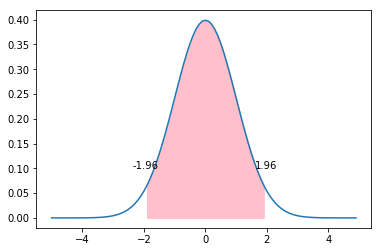

In [146]:
fill_condition = (x > stats.norm(loc=0, scale=1).ppf(0.025)) & (x<stats.norm(loc=0, scale=1).ppf(0.975))
plt.plot(x, y1)
plt.fill_between(x[fill_condition], y1[fill_condition], color='pink')
plt.text(x=stats.norm(loc=0, scale=1).ppf(0.025), y=0.1,
         s=str(np.round(stats.norm(loc=0, scale=1).ppf(0.025), 2)), ha='center')
plt.text(x=stats.norm(loc=0, scale=1).ppf(0.975), y=0.1,
         s=str(np.round(stats.norm(loc=0, scale=1).ppf(0.975), 2)), ha='center')

On pourrait aussi être intéressé à l'intervalle de confiance sur la moyenne. En effet, la moyenne suit aussi une distribution normale, dont la tendance centrale est la moyenne de la distribution, et dont l'écart-type est noté *erreur standard*. On calcule cette erreur en divisant la variance par le nombre d'observation. Ainsi, pour 5 échantillons:

Text(0.391993,0.1,'0.39')

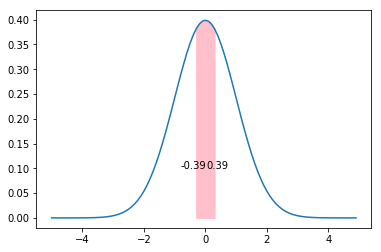

In [147]:
standard_error = stats.norm(loc=0, scale=1/5).ppf(0.975) # égal à l'inverse de 0.025. notez l'échelle divisée par 5

fill_condition = (x > -standard_error) & (x < standard_error)
plt.plot(x, y1)
plt.fill_between(x[fill_condition], y1[fill_condition], color='pink')
plt.text(x=-standard_error, y=0.1, s=str(np.round(-standard_error, 2)), ha='center')
plt.text(x=standard_error, y=0.1, s=str(np.round(standard_error, 2)), ha='center')

### Poisson

La loi de Poisson (avec un P majuscule, introduite par le mathématicien français Siméon Denis Poisson) décrit des distributions discrètes de probabilité d'un nombre d'événements se produisant dans l'espace ou dans le temps. Les distributions de Poisson décrive ce qui tient du décompte. Il peut s'agir du nombre de grenouilles traversant une rue quotidiennement, du nombre de plants d'asclépiades se trouvant sur une terre cultivée, ou du nombre d'événemnts de précipitation au mois de juin, etc. La distribution de poisson n'a qu'un seul paramètre, $\lambda$, qui décrit tant la moyenne du décompte.

Par exemple, en un mois de 30 jours, et une moyenne de 8 événements de précipitation pour ce mois, on obtient la distribution suivante.

La somme des probabilités est de 0.999999999463


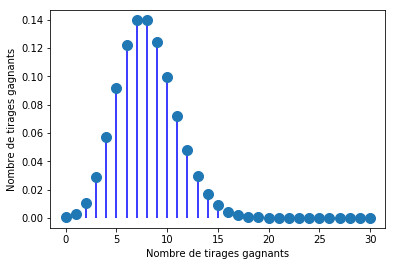

In [151]:
x = np.arange(31)
y = stats.poisson(8).pmf(x)
print('La somme des probabilités est de', y.sum())

plt.plot(x, y, 'o', markersize=10)
plt.vlines(x, 0, y, color='blue')
plt.xlabel('Nombre de tirages gagnants')
plt.ylabel('Nombre de tirages gagnants');

### Exponentielle
### Beta

## Tests statistiques



### Variance, covariance et corrélation

### Test de t

### ANOVA
- Anova sens unique
- Anova double sens

### MANOVA et MANCOVA
Tout comme les ANOVA et les ANCOVA supposent que les les données sont distribuées normalement, les MANOVA et MANCOVA supposent des données multinormales. La multinornalité des données peut être testée avec un test de M (Box's M test).

### Modélisation linéaire
- GLM
- dummification des facteurs et matrices de concept
- Régression linéaire (lmplot, residplot)



### Analyse de covariance

### Modélisation mixte

L'outil que je privilégie en biostatistique est le modèle linéaire mixte, qui consiste à intégrer dans un modèle linéaire autant des effets fixes que des effets aléatoires.

## Erreurs communes

### Un résultat montrant une p-value plus élevée que 0.05 n'est pas pertinent

Lors d'une conférence, Dr Evil ne présentent que les résultats significatifs de ses essais au seuil de 0.05. Certains essais ne sont pas significatifs, mais bon, ceux-ci ne sont pas importants... En écartant ces résultats, Dr Evil commet 3 erreurs:

1. La p-value n'est pas un bon indicateur de l'importance d'un test statistique. L'importance d'une variable dans un modèle linéaire devrait être évaluée par la valeur de son coefficient. Son incertitude devrait être évaluée par sa variance. Une manière d'évaluer plus intuitive la variance est l'écart-type ou l'intervalle de confiance. À un certain seuil d'intervalle de confiance, la p-value traduira la probabilité qu'un coefficient soit réellement nul ait pu générer des données démontrant un coefficient égal ou supérieur.
2. Il est tout aussi important de savoir que le traitement fonctionne que de savoir qu'il ne fonctionne pas. Les résultats démontrant des effets sont malheureusement davantage soumis aux journaux et davantage publiés que ceux ne démontrant pas d'effets ([Decullier et al., 2005]( https://doi.org/10.1136/bmj.38488.385995.8F )).
3. Le seuil de 0.05 est arbitraire.

